# Final Project - LES Rainfall prediction

- Submitted by Mubin Modi, Mitali Chouthai, Meghna Havalgi


## Contents 
- Introduction
- Data Preparation
    - Data Used :
        - Satelite Images of Cloud Cover
        - Meteorological Data
    - Processing :
        - Redundant Variables Drop 
        - Missing Values
        - Slicing of Images into 8hr buckets
        - Slicing of Meteo Data into 24 hr buckets
        - Creating a sliding window Precipitation (Target Label)
        - Min-Max Scaling
- Modeling:
    - Encoder-Decoder Architecture (ConvLSTM + LSTM)
    - Predictions
    - Performance Confusion Matrix
    - Prediction Examples
- Conclusion

## Data Description


This dataset contains hourly indexed GOES satellite imagery data and meteorology data, from `October 1, 2006 0:00` to `March 31, 2017 23:00`.


| Column Name           | Data Category     | Data Type                  | Description                                                  |
| :--------------------- | :-----------------: | :--------------------------: | :------------------------------------------------------------ |
| Date_UTC              | Timestamp         | `<String>`                 | The date of the data in the row in UTC timezone. This timezone is used by GOES satellites and the file naming follows the same convention. |
| Time_UTC              | Timestamp         | `<String>`                 | The time of the data in the row in UTC timezone. This timezone is used by GOES satellites and the file naming follows the same convention. |
| Date_CST              | Timestamp         | `<String>`                 | The date of the data in the row in UTC timezone. This timezone is used by weather station while collecting meteorology data. |
| Time_CST              | Timestamp         | `<String>`                 | The time of the data in the row in UTC timezone. This timezone is used by weather station while collecting meteorology data. |
| File_name_for_1D_lake | I/O               | `<String>`                 | The corresponding raw data file where the GOES satellite imagery data was extracted. Files can be found on server***. |
| File_name_for_2D_lake | I/O               | `<String>`                 | The corresponding processed data file where the GOES satellite imagery data was extracted. Files can be found on server***. |
| Lake_data_1D          | Satellite Imagery | `Array[<Float>]`           | 1-D array of floating point numbers which represent the flattened cloud pixel intensity of Lake Michigan area. The array has a length of `3,599`. |
| Lake_data_2D          | Satellite Imagery | `Array[Array[<Float>], …]` | 2-D array of floating point numbers which represent the cloud pixel intensity of Lake Michigan area. The structure of the array is: [[col 1], [col 2], ..], data can be used to reconstruct a 106 x 79 matrix. |
| Temp (F)              | Meteorology       | `<Integer>`                | Temperature (°F Dry Bulb)                                    |
| RH (%)                | Meteorology       | `<Float>`                  | Relative Humidity (%)                                        |
| Dewpt (F)             | Meteorology       | `<Integer>`                | Dew Point Temperature (°F)                                   |
| Wind Spd (mph)        | Meteorology       | `<Float>`                  | Wind Speed (mph)                                             |
| Wind Direction (deg)  | Meteorology       | `<Float>`                  | Wind Direction (degrees, measured every 10 degrees)          |
| Peak Wind Gust(mph)   | Meteorology       | `<Float>`                  | Wind Gust (mph)                                              |
| Low Cloud Ht (ft)     | Meteorology       | `<Float>`                  | Cloud Height—Lower Level of Cloud (feet)                     |
| Med Cloud Ht (ft)     | Meteorology       | `<Float>`                  | Cloud Height—Med Level of Cloud (feet)                       |
| High Cloud Ht (ft)    | Meteorology       | `<Float>`                  | Cloud Height—Upper Level of Cloud (feet)                     |
| Visibility (mi)       | Meteorology       | `<Float>`                  | Visibility (miles)                                           |
| Atm Press (hPa)       | Meteorology       | `<Float>`                  | Atmospheric Pressure (hPa, hecto-Pascals)                    |
| Sea Lev Press (hPa)   | Meteorology       | `<Float>`                  | Sea Level Pressure (hPa, hecto-Pascals)                      |
| Altimeter (hPa)       | Meteorology       | `<Float>`                  | Altimeter (hPa, hecto-Pascals)                               |
| Precip (in)           | Meteorology       | `<Float>`                  | Precipitation (inches)                                       |
| Wind Chill (F)        | Meteorology       | `<Integer>`                | Wind Chill (°F)                                              |
| Heat Index (F)        | Meteorology       | `<Integer>`                | Heat Index (°F)                                              |

**Non-numeric labels in meteorology data:**

> Missing values are indicated by "M" and "m". When observations note specific values as missing, "M" is used. The "m" is used when there is a lack of information from the observation.

`Lake_data_1D`: 

Each value in the array corresponds to a pixel within the Lake Michigan area. The longitude and latitude values of these pixels can be found in `2006Fall_2017Spring_GOES_meteo_combined.csv`. There are 3,599 data points which covers the Lake Michigan area.

`Lake_data_2D`: 

The 2-D array can be utilized to create a rectangular region that encompasses the Lake Michigan area. The area covers latitudes ranging from 41.78 to 45.98 with an increment of 0.04, and longitudes ranging from -87.90 to -84.78 with an increment of 0.04.

## 1) Introduction

In this project we need to create an amalgamation of CNN & RNN models to accurately forecast precipitaion of rain at Lake michigan and categorize into 4 categories: low, medium, high, none. But first we have tried to predict if 2 classes rain or no rain
We have ~15K satelite images of lake michigan with frequent cloud cover and subsequent weather forecast specific variables with data at hour level <div>

We started with first creating a mapping between the images and the weather forecast data and then figured out how to structure our data to model forecating. It's important to note given it's forecasting we will also not have images for the following days to predict the precipitation, hence we have to create a sliding window based data and then train our models on it <div>

When we created the mapping, we observed that it is not necessary that there is clear match with precipitation and cloud image, but it would be sequence of images representing the flow of clouds over Lake Michigan which would indicate if it rains or not and the precipitation levels <div>

This was a critical finding and with Professor's hint on using `ConvLSTM` for the sequence of images, we were able to connect the dots. We then worked on to create classic Encoder-Decoder style architecture to use `ConvLSTM` for extracting feature from sequence of images, and `LSTM` for the time series Meteorological <div>


## How are the images generated?

We did the preprocessing in a different NB and generated images 

## 2) Data Preparation

### Importing Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, LSTM, ConvLSTM2D, Dense, Add, Dropout, Flatten, Reshape
from keras.layers import TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

### Importing Satelite Images of Lake Michigan

These are preprocessed images specifically focused on cloud cover on lake michigan ~15K in total

Loading images then converting them to numpy array

If valid images are found, they are batched using TensorFlow's timeseries_dataset_from_array function. This function is particularly useful for preparing datasets for time series forecasting models like LSTMs or ConvLSTMs.


In [2]:
import numpy as np

#Loading images correctly
images = []
for idx in tqdm(range(12000)):
    im_path = f'C:/Users/Administrator/Desktop/Files/NN/images/lake-michigan-images-64-combined/{idx}.png'
    im = cv2.imread(im_path)
    if im is not None:
        images.append(im)
    else:
        print(f"Failed to load the image: {im_path}")

#Converting images to numpy array
images = np.array(images)

#Checking if the image data is valid
if images.size > 0:
    cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(
        images[:10000], None, 8, sequence_stride=8, sampling_rate=1, batch_size=10000
    )

    for batch in cloud_train_batched:
        print(batch.shape)
        break  
else:
    print("No valid image data found.")

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1850.54it/s]


(1250, 8, 64, 64, 3)


### Reading the Meteorological data

LES Meteorological data consists of many features with the target variable of Precipitation starting from 2006 to 2017. We would focus on relevant 10 features like Temperature, Dew point etc and create a smaller subset

In [3]:
les = pd.read_csv(r"D:\Data\2006Fall_2017Spring_GOES_meteo_combined.csv")

In [4]:
# Renaming
les.rename(columns={ "Temp (F)": "Temp_F", "RH (%)": "RH_pct",
                   "Dewpt (F)" : "Dewpt_F", "Wind Spd (mph)" : "Wind_Spd_mph",
                   "Wind Direction (deg)" : "Wind_Direction_deg", "Peak Wind Gust(mph)" : "Peak_Wind_Gust_mph",
                   "Low Cloud Ht (ft)" : "Low_Cloud_Ht_ft", "Med Cloud Ht (ft)" : "Med_Cloud_Ht_ft",
                   "High Cloud Ht (ft)" : "High_Cloud_Ht_ft", "Visibility (mi)" : "Visibility_mi",
                   "Atm Press (hPa)" : "Atm_Press_hPa", "Sea Lev Press (hPa)" : "Sea_Lev_Press_hPa",
                   "Altimeter (hPa)" : "Altimeter_hPa", "Precip (in)" : "Precip_in",
                   "Wind Chill (F)" : "Wind_Chill_F", "Heat Index (F)" : "Heat_Index_F",
                   } , inplace = True)

les.head()

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,Wind_Chill_F,Heat_Index_F
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC


The original dataset begins at 00:00 UTC, extends to 23:00, and then returns to 00:00 of the next day.

Central Standard Time (North America) typically lags 6 hours behind UTC. However, Traverse City, Michigan operates on GMT/UTC - 5 hours during Standard Time and GMT/UTC - 4 hours during Daylight Saving Time

Replacing missing values with 0 and dropping the columns WindChill and Heat Index due to a large number of NC values

In [5]:
les = les.replace(['m', 'M'], '0')
les = les.drop(['Wind_Chill_F', 'Heat_Index_F'], axis=1)
les = les.reset_index(drop=True)
les = les.dropna(subset = ['Temp_F'])

In [6]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

### Dropping highly correlated features

Some highly correlated and redundant features are removed from the dataset. These include 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', and potentially 'Altimeter_hPa', due to its high correlation with 'Atm_Press_hPa'

In [7]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

In [8]:
meteo_les = les.drop(
    [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 
     'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa' ], axis=1)

In [9]:
meteo_les.head()

,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Precip_in
0,48,86,7,150,4100,4800,7000,10,984.0,1007.00,0.00
1,48,86,8,150,6000,0,0,10,983.7,1006.50,0.00
2,48,86,6,0,5500,11000,0,10,982.7,1005.70,0.00
3,48,86,8,150,6000,0,0,10,982.0,1005.10,0.00
4,48,89,5,0,2200,3500,0,8,982.0,1004.90,0.02


In [10]:
len(meteo_les)

47882

### Creating Slices of 24hr with Meteo data

We create slices with 24 hours of data to represent daily observations

This method of slicing is crucial for modeling as it structures the data into a format suitable for time-series analysis, enabling the model to recognize patterns across each day.

In [11]:
x3 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [12]:
for batch in x3:
    print(batch.shape)
    print('--')

(1250, 24, 11)
--


The dataset comprises 1250 observations of 24-hour meteorological data, each containing 11 features. For training and validation split we would use initial 30000 data points for `Train` and rest for `Validation` data

In [13]:
meteo_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [14]:
meteo_train_batched

<BatchDataset element_spec=TensorSpec(shape=(None, None, 11), dtype=tf.string, name=None)>

In [15]:
def convert_byte_tensor_to_float(tensor):
    string_tensor = tf.strings.regex_replace(tensor, '^b\'(.*)\'$', '\\1')
    float_tensor = tf.strings.to_number(string_tensor, out_type=tf.float32)
    return float_tensor

In [16]:
meteo_train = None
for batch in meteo_train_batched:
    meteo_train = batch
    print(meteo_train.shape)
    print('--')

(1250, 24, 11)
--


In [17]:
print(meteo_train[0])

tf.Tensor(
[[b'48' b'86' b'7' b'150' b'4100' b'4800' b'7000' b'10' b'984.0'
  b'1007.00' b'0.00']
 [b'48' b'86' b'8' b'150' b'6000' b'0' b'0' b'10' b'983.7' b'1006.50'
  b'0.00']
 [b'48' b'86' b'6' b'0' b'5500' b'11000' b'0' b'10' b'982.7' b'1005.70'
  b'0.00']
 [b'48' b'86' b'8' b'150' b'6000' b'0' b'0' b'10' b'982.0' b'1005.10'
  b'0.00']
 [b'48' b'89' b'5' b'0' b'2200' b'3500' b'0' b'8' b'982.0' b'1004.90'
  b'0.02']
 [b'48' b'89' b'6' b'0' b'2700' b'5500' b'7500' b'10' b'981.7' b'1004.60'
  b'0.01']
 [b'42' b'95' b'0' b'0' b'4600' b'0' b'0' b'8' b'991.7' b'1014.80'
  b'0.00']
 [b'43' b'96' b'0' b'0' b'3900' b'0' b'0' b'10' b'992.3' b'1015.60'
  b'0.00']
 [b'48' b'92' b'0' b'0' b'3600' b'0' b'0' b'10' b'993.0' b'1016.30'
  b'0.00']
 [b'55' b'59' b'11' b'300' b'3600' b'0' b'0' b'10' b'993.7' b'1016.90'
  b'0.00']
 [b'55' b'61' b'10' b'300' b'3600' b'0' b'0' b'10' b'994.3' b'1017.50'
  b'0.00']
 [b'58' b'55' b'8' b'290' b'3600' b'0' b'0' b'10' b'995.0' b'1018.00'
  b'0.00']
 [b'56' b'

Removing the byte representation from the data

In [18]:
meteo_train = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    meteo_train,
    dtype=tf.float32)

In [19]:
meteo_train.shape

TensorShape([1250, 24, 11])

Summing the precipitation values for each hour of the day 

In [20]:
rain_train = []

for sample in meteo_train:
    last_column = sample[:, -1]

    # Sum the values in the last column
    rain_sum = tf.reduce_sum(last_column)

    # Append the sum to rain_train
    rain_train.append(rain_sum)

rain_train = tf.stack(rain_train)

## Create classes- Class 1 and Class 0

In [21]:
# if > 0.10 inches of rain, then rain = 1, else rain = 0
rain_train_b = tf.where(rain_train > 0.10, 1, 0)

In [22]:
len(rain_train_b)

1250

As we can observe below, there are only 190 days, where it rains which makes the data highly imbalanced. We'll be treating the imabalance going forward, with class-weights during our training

In [23]:
pd.Series(rain_train_b.numpy()).value_counts()

0    1060
1     190
Name: count, dtype: int64

Dropping the precipitation column from the meteo training data

In [24]:
meteo_train = meteo_train[:, :, :-1]
print(meteo_train.shape)

(1250, 24, 10)


### Min-Max Scaling

Scaling is an important step to create a scaled data as it avoids any unnecessary spikes in the data and ensures better training for the model

In [25]:
scaler = MinMaxScaler()

n_samples, n_timesteps, n_features = meteo_train.shape
meteo_train= tf.reshape(meteo_train, [n_samples * n_timesteps, n_features])
meteo_train = meteo_train.numpy()
meteo_train = scaler.fit_transform(meteo_train)
meteo_train = tf.reshape(meteo_train, [n_samples, n_timesteps, n_features]).numpy()

In [26]:
meteo_train.shape

(1250, 24, 10)

**The validation dataset for imagery begins at index 13,050, with a total of 15,959 instances of imagery recorded. The last 2,500 instances of imagery are designated as the validation dataset, excluding some intermediate 'nan' instances. This corresponds to 7,500 rows of meteorological data**

**Creates a dataset of sliding windows over a timeseries provided as array.**

In [27]:
meteo_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[:7500], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=7500)

In [28]:
meteo_val = None
for batch in meteo_val_batched:
    meteo_val = batch
    print(meteo_val.shape)
    print('--')

(312, 24, 11)
--


In [29]:
meteo_val = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    meteo_val,
    dtype=tf.float32)

In [30]:
rain_val= []

for sample in meteo_val:
    last_column = sample[:, -1]

    rain_sum = tf.reduce_sum(last_column)

    rain_val.append(rain_sum)

rain_val = tf.stack(rain_val)

In [31]:
# if > 0.10 inches of rain, then rain = 1, else rain = 0
rain_val_b = tf.where(rain_val > 0.10, 1, 0)

In [32]:
rain_val_b

<tf.Tensor: shape=(312,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [33]:
meteo_val = meteo_val[:, :, :-1]

## Scaling Validation data based on the train values

In [34]:
n_samples_val, n_timesteps_val, n_features_val = meteo_val.shape
meteo_val = tf.reshape(meteo_val, [n_samples_val * n_timesteps_val, n_features_val])
meteo_val = meteo_val.numpy()
meteo_val = scaler.transform(meteo_val)
meteo_val = tf.reshape(meteo_val, [n_samples_val, n_timesteps_val, n_features_val]).numpy()

In [35]:
meteo_val.shape

(312, 24, 10)

In [36]:
print(len(images))

12000


So we have about 3 times more training data than test data.

### Creating Image data 8hr window slices 

Our training dataset will consist of 8 hour sequence of images and the label will be rain or not for *the next day* (Sliding window 1-day shift)

In [37]:
cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 8, sequence_stride=8, 
                                                                           sampling_rate=1, batch_size=10000)

In [38]:
cloud_train = None
for batch in cloud_train_batched:
    cloud_train = batch
    cloud_train = np.expand_dims(cloud_train, axis=-1)
    print(cloud_train.shape)
    cloud_train = cloud_train / 255
    print('--')

(1250, 8, 64, 64, 3, 1)
--


For Validation set we take the last 2500 values

In [39]:
cloud_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 8, sequence_stride=8, 
                                                                         sampling_rate=1, batch_size=2500)

In [40]:
cloud_val = None
for batch in cloud_val_batched:
    cloud_val = batch
    cloud_val = np.expand_dims(cloud_val, axis=-1)
    print(cloud_val.shape)
    cloud_val = cloud_val / 255
    print('--')

(312, 8, 64, 64, 3, 1)
--


In [41]:
# Assign rain train c as array from rain train b
rain_train_c = rain_train_b.numpy()

In [42]:
rain_val_c = rain_val_b.numpy()

the goal is to predict the next value based on previous data, aligning the current label with the previous timestep’s features.

In [43]:
rain_train_c_mod = [rain_train_c[x+1] for x in range(len(rain_train_c)-1)]
len(rain_train_c_mod)

1249

In [44]:
rain_val_c_mod = [rain_val_c[x+1] for x in range(len(rain_val_c)-1)]

In [45]:
print(rain_train_c[0:10], rain_train_c_mod[0:10])

[0 0 1 0 1 0 0 0 0 0] [0, 1, 0, 1, 0, 0, 0, 0, 0, 1]


In [46]:
cloud_train.shape, rain_train_c.shape, cloud_val.shape, rain_val_c.shape

((1250, 8, 64, 64, 3, 1), (1250,), (312, 8, 64, 64, 3, 1), (312,))

## Modelling

We are using encoder-decoder architecture. Here we are using ConvLSTm for image feature extraction.
We are using LSTM for meteo time series data. We combine these two and feed it to the decoder layer. In the decoder layer we have LSTM and it generates the output forecast

In [47]:
# Drop the last value from each of the training datasets
meteo_train = meteo_train[:-1]
cloud_train = cloud_train[:-1]

# Drop the last value from each of the validation datasets
meteo_val = meteo_val[:-1]
cloud_val = cloud_val[:-1]

In [48]:
meteo_train = np.asarray(meteo_train)
cloud_train = np.asarray(cloud_train)
rain_train_c_mod = np.asarray(rain_train_c_mod)

meteo_val = np.asarray(meteo_val)
cloud_val = np.asarray(cloud_val)
rain_val_c_mod = np.asarray(rain_val_c_mod)

In [49]:
print(meteo_train.shape, cloud_train.shape, rain_train_c_mod.shape, meteo_val.shape, cloud_val.shape, rain_val_c_mod.shape)

(1249, 24, 10) (1249, 8, 64, 64, 3, 1) (1249,) (311, 24, 10) (311, 8, 64, 64, 3, 1) (311,)


## Model Architecture

We are using LSTM layers to process the meteo data and ConvLSTM2D for spatial temporal cloud imagery. We merge both the features and then merged features are decoded in the decoder layer by using additional LSTM layers and dropout regularization and finally passed through a dense layer to predict the precipitation.

1. Input Layers:
   Two input layers are defined: meteo_input and cloud_input.
   meteo_input has a shape of (24, 10), suggesting it's for meteorological data with 24 time steps and 10  features per step.
   cloud_input has a shape of (8, 64, 64, 3), suggesting it's for cloud image data with 8 time steps and images  of size 64x64 pixels with 3 channels (RGB).
2. Encoder Layers:
   LSTM for Meteorological Data:
   An LSTM layer with 64 units processes the meteorological data and returns sequences.
   A dropout layer with a dropout rate of 0.3 is applied to mitigate overfitting.
   Another LSTM layer with 32 units processes the output of the previous layer and does not return sequences.
   Batch normalization is applied to normalize the activations of this layer.
   ConvLSTM for Cloud Data:
   Two ConvLSTM2D layers process the cloud image data.
   The first layer has 16 filters and returns sequences, followed by dropout regularization.
   The second layer has 32 filters and does not return sequences, followed by batch normalization.
3. Combining Features:
   The outputs of the LSTM and ConvLSTM layers are combined element-wise using an addition operation (Add()).   This merges the representations learned from both data streams.
4. Pooling:
   Global average pooling (GlobalAveragePooling2D()) is applied to reduce the spatial dimensions of the combined features while retaining important information.
5. Decoder Layers:
   The pooled features are passed through a dense layer with 64 units and ReLU activation.
   Dropout regularization with a dropout rate of 0.3 is applied to mitigate overfitting.
   Finally, a dense layer with 1 unit and sigmoid activation is used to predict binary output (e.g.,  precipitation).
6. Compilation:
   The model is compiled using the Adam optimizer with a learning rate of 0.0001, binary cross-entropy loss function, and accuracy metric.
7. Summary:
   The model.summary() method is used to display a summary of the model architecture, including the type and shape of each layer, as well as the total number of parameters.

In [50]:
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, BatchNormalization, GlobalAveragePooling2D, Dense, Reshape, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specifying the input shapes
meteo_input = Input(shape=(24, 10))
cloud_input = Input(shape=(8, 64, 64, 3))

## Encoder Layers 

# Starting with LSTM for Meteorological Data 
lstm_encoder = LSTM(64, return_sequences=True)(meteo_input)
lstm_encoder = Dropout(0.3)(lstm_encoder)
lstm_encoder = LSTM(32, return_sequences=False)(lstm_encoder)
lstm_encoder = BatchNormalization()(lstm_encoder)

# Followed by ConvLSTM for Cloud Data
convlstm_1 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_input)
convlstm_1 = Dropout(0.3)(convlstm_1)
convlstm_2 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False)(convlstm_1)
convlstm_2 = BatchNormalization()(convlstm_2)

# Combining the outputs of the LSTM and ConvLSTM layers
combined_features = Add()([lstm_encoder, convlstm_2])

# Reduce spatial dimensions before reshaping
pooled = GlobalAveragePooling2D()(combined_features)

# Decoder Layers
decoder_1 = Dense(64, activation='relu')(pooled)
decoder_1 = Dropout(0.3)(decoder_1)
output = Dense(1, activation='sigmoid')(decoder_1)

model_lstm_ml = Model(inputs=[meteo_input, cloud_input], outputs=output)

new_learning_rate = 0.0001
optimizer = Adam(learning_rate=new_learning_rate)

model_lstm_ml.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_lstm_ml.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 10)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 8, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 64)       19200       ['input_1[0][0]']                
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 8, 64, 64, 1  11008       ['input_2[0][0]']            

Adding class weights to the data 80% for class 1 and 20% for class 0 to handle the imapct of class imbalance, we chose 80% to counter-allocate the class imabalance of the labels

Class weights are used to address class imbalance in the training data, where one class (in this case, class 1 for rain) might be significantly underrepresented compared to another class (class 0 for not rain).

1. Desired Weight for Class 1 (Rain):
desired_weight_class1 is set to 0.80, indicating that the model should prioritize correct predictions for class 1 (rain) and assign it a higher weight during training.
2. Weight Calculation for Class 0 (Not Rain):
weight_class0 is calculated as 1 minus the desired weight for class 1. This ensures that the sum of weights for both classes is equal to 1.
3. Class Weight Dictionary:
class_weight_dict is created as a dictionary where class 0 (not rain) is assigned the weight calculated earlier, and class 1 (rain) is assigned the desired weight.
4. Training:
The fit() method is called on the model with the training data, labels, and additional parameters.
The class_weight parameter is set to class_weight_dict, indicating that the specified class weights should be used during training to adjust the loss function accordingly.

In [51]:
# Define the desired weight for class 1 (rain)
desired_weight_class1 = 0.80

# Calculate the weight for class 0 (not rain)
weight_class0 = 1 - desired_weight_class1

# Create the class weight dictionary
class_weight_dict = {0: weight_class0, 1: desired_weight_class1}



history = model_lstm_ml.fit(
    [meteo_train, cloud_train],
    rain_train_c_mod,
    epochs=50,
    batch_size=10,
    validation_data=([meteo_val, cloud_val], rain_val_c_mod),
    class_weight=class_weight_dict)

Epoch 1/50
125/125 [==============================] - 48s 267ms/step - loss: 0.2093 - accuracy: 0.5204 - val_loss: 0.6658 - val_accuracy: 0.8071
Epoch 2/50
125/125 [==============================] - 32s 256ms/step - loss: 0.2059 - accuracy: 0.5717 - val_loss: 0.6731 - val_accuracy: 0.7074
Epoch 3/50
125/125 [==============================] - 32s 256ms/step - loss: 0.1990 - accuracy: 0.6333 - val_loss: 0.6834 - val_accuracy: 0.5756
Epoch 4/50
125/125 [==============================] - 32s 255ms/step - loss: 0.1942 - accuracy: 0.6453 - val_loss: 0.7028 - val_accuracy: 0.4952
Epoch 5/50
125/125 [==============================] - 32s 255ms/step - loss: 0.1885 - accuracy: 0.6821 - val_loss: 0.6887 - val_accuracy: 0.5273
Epoch 6/50
125/125 [==============================] - 32s 255ms/step - loss: 0.1870 - accuracy: 0.6950 - val_loss: 0.6916 - val_accuracy: 0.5273
Epoch 7/50
125/125 [==============================] - 32s 255ms/step - loss: 0.1885 - accuracy: 0.6613 - val_loss: 0.6833 - val_ac

In [52]:
model_lstm_ml.save('24_deep_model.h5')

In [53]:
predictions = model_lstm_ml.predict([meteo_val, cloud_val])

predicted_labels = (predictions > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(rain_val_c_mod, predicted_labels))

10/10 [==============================] - 3s 202ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       263
           1       0.41      0.33      0.37        48

    accuracy                           0.82       311
   macro avg       0.65      0.62      0.63       311
weighted avg       0.81      0.82      0.82       311



1. Precision: Precision measures the accuracy of positive predictions. It is calculated as the ratio of true positives to the sum of true positives and false positives. In this case, the precision for class 0 (not rain) is 0.88, and for class 1 (rain) it is 0.41. This indicates that the model is better at predicting class 0 compared to class 1.
2. Recall: Recall (also known as sensitivity) measures the proportion of actual positives that are correctly identified by the model. It is calculated as the ratio of true positives to the sum of true positives and false negatives. Here, the recall for class 0 is 0.91, and for class 1 it is 0.33. This means the model is better at capturing class 0 instances compared to class 1 instances.
3. F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The F1-score for class 0 is 0.90, and for class 1 it is 0.37. This indicates that the model performs better overall on class 0 than on class 1.
4. Support: Support refers to the number of actual occurrences of the class in the specified dataset. In this case, there are 263 instances of class 0 and 48 instances of class 1 in the dataset.
5. Accuracy: Accuracy measures the overall correctness of the model's predictions. It is calculated as the ratio of correctly predicted instances to the total number of instances. Here, the accuracy is 0.82, indicating that the model correctly predicts the class for approximately 82% of instances in the dataset.
6. Macro Average and Weighted Average: These are the average scores for precision, recall, and F1-score, calculated separately for each class and then averaged. Macro average treats all classes equally, while weighted average takes into account the number of instances for each class.

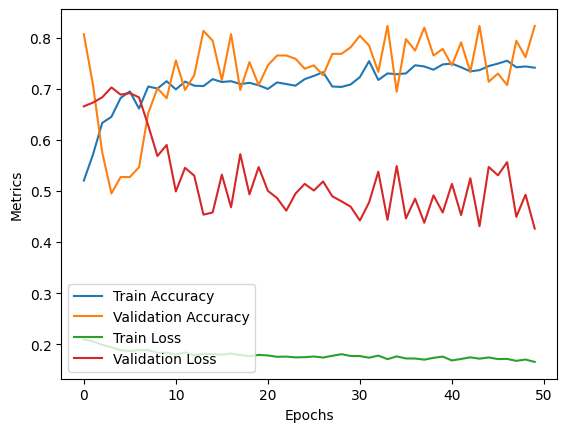

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [56]:
pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod]).T
pred_df.columns = ['actual', 'predicted']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]

In [57]:
pred_df[pred_df['actual'] == 0].value_counts()

actual  predicted  Predictions_correct
0       0          True                   240
        1          False                   32
Name: count, dtype: int64

In [58]:
pred_df[pred_df['actual'] == 1].value_counts()

actual  predicted  Predictions_correct
1       0          False                  23
        1          True                   16
Name: count, dtype: int64

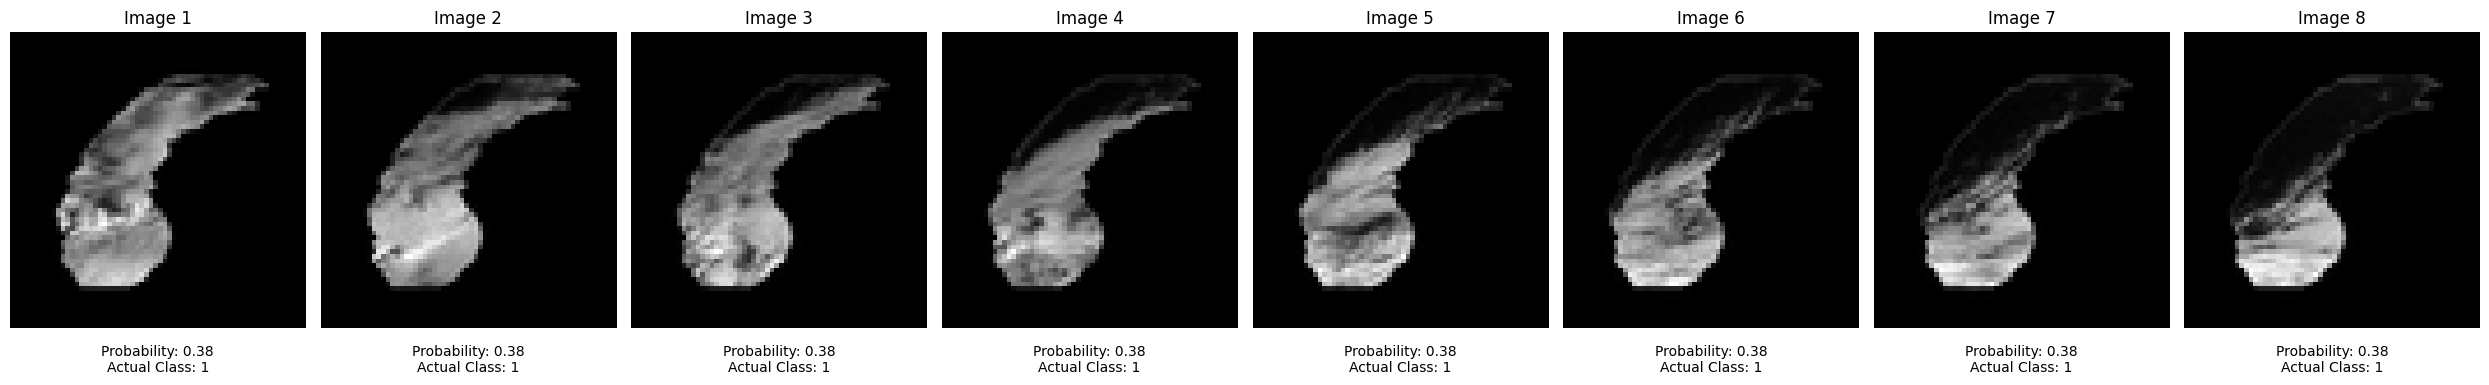

In [59]:
num_images = len(cloud_val[0]) #no of images in a single batch

fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(cloud_val[3][i][:, :, 0], cmap='gray')  
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')  # Turn off axis
    
    # Extract the predicted probability and actual class for the i-th image
    probability = predictions[3][0]  
    actual_class = rain_val_c_mod[3]  
    
    ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
            transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

**Plot the images for Reference**

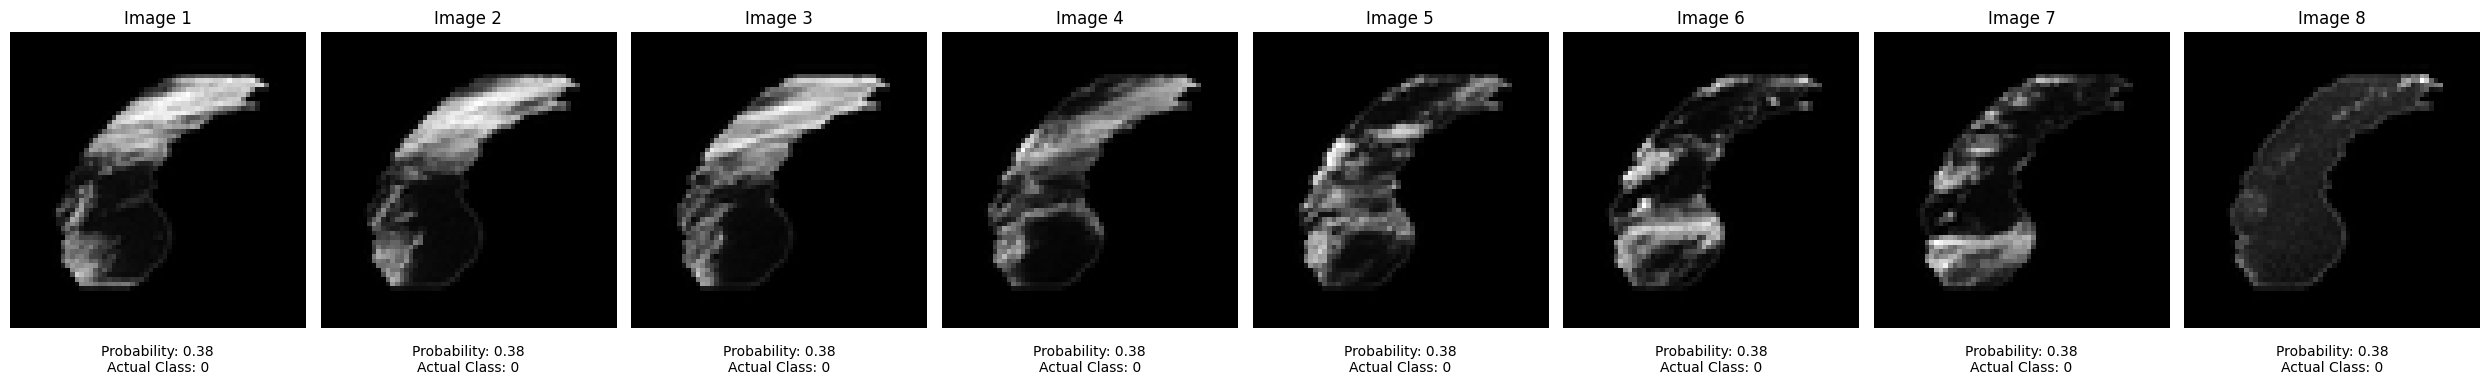

In [60]:
num_images = len(cloud_val[0]) #no of images in a single batch

fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(cloud_val[4][i][:, :, 0], cmap='gray')  
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')  # Turn off axis
    
    probability = predictions[4][0]  
    actual_class = rain_val_c_mod[4]  
    
    ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
            transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

**Load the model**

In [61]:
from tensorflow.keras.models import load_model

model = load_model('24_deep_model.h5')


In [62]:
from sklearn.metrics import classification_report

predictions = model.predict([meteo_val, cloud_val])

predicted_labels = (predictions > 0.5).astype(int)

# print(classification_report(rain_val_c_mod, predicted_labels))

10/10 [==============================] - 3s 168ms/step


**Predicting for 3 days**

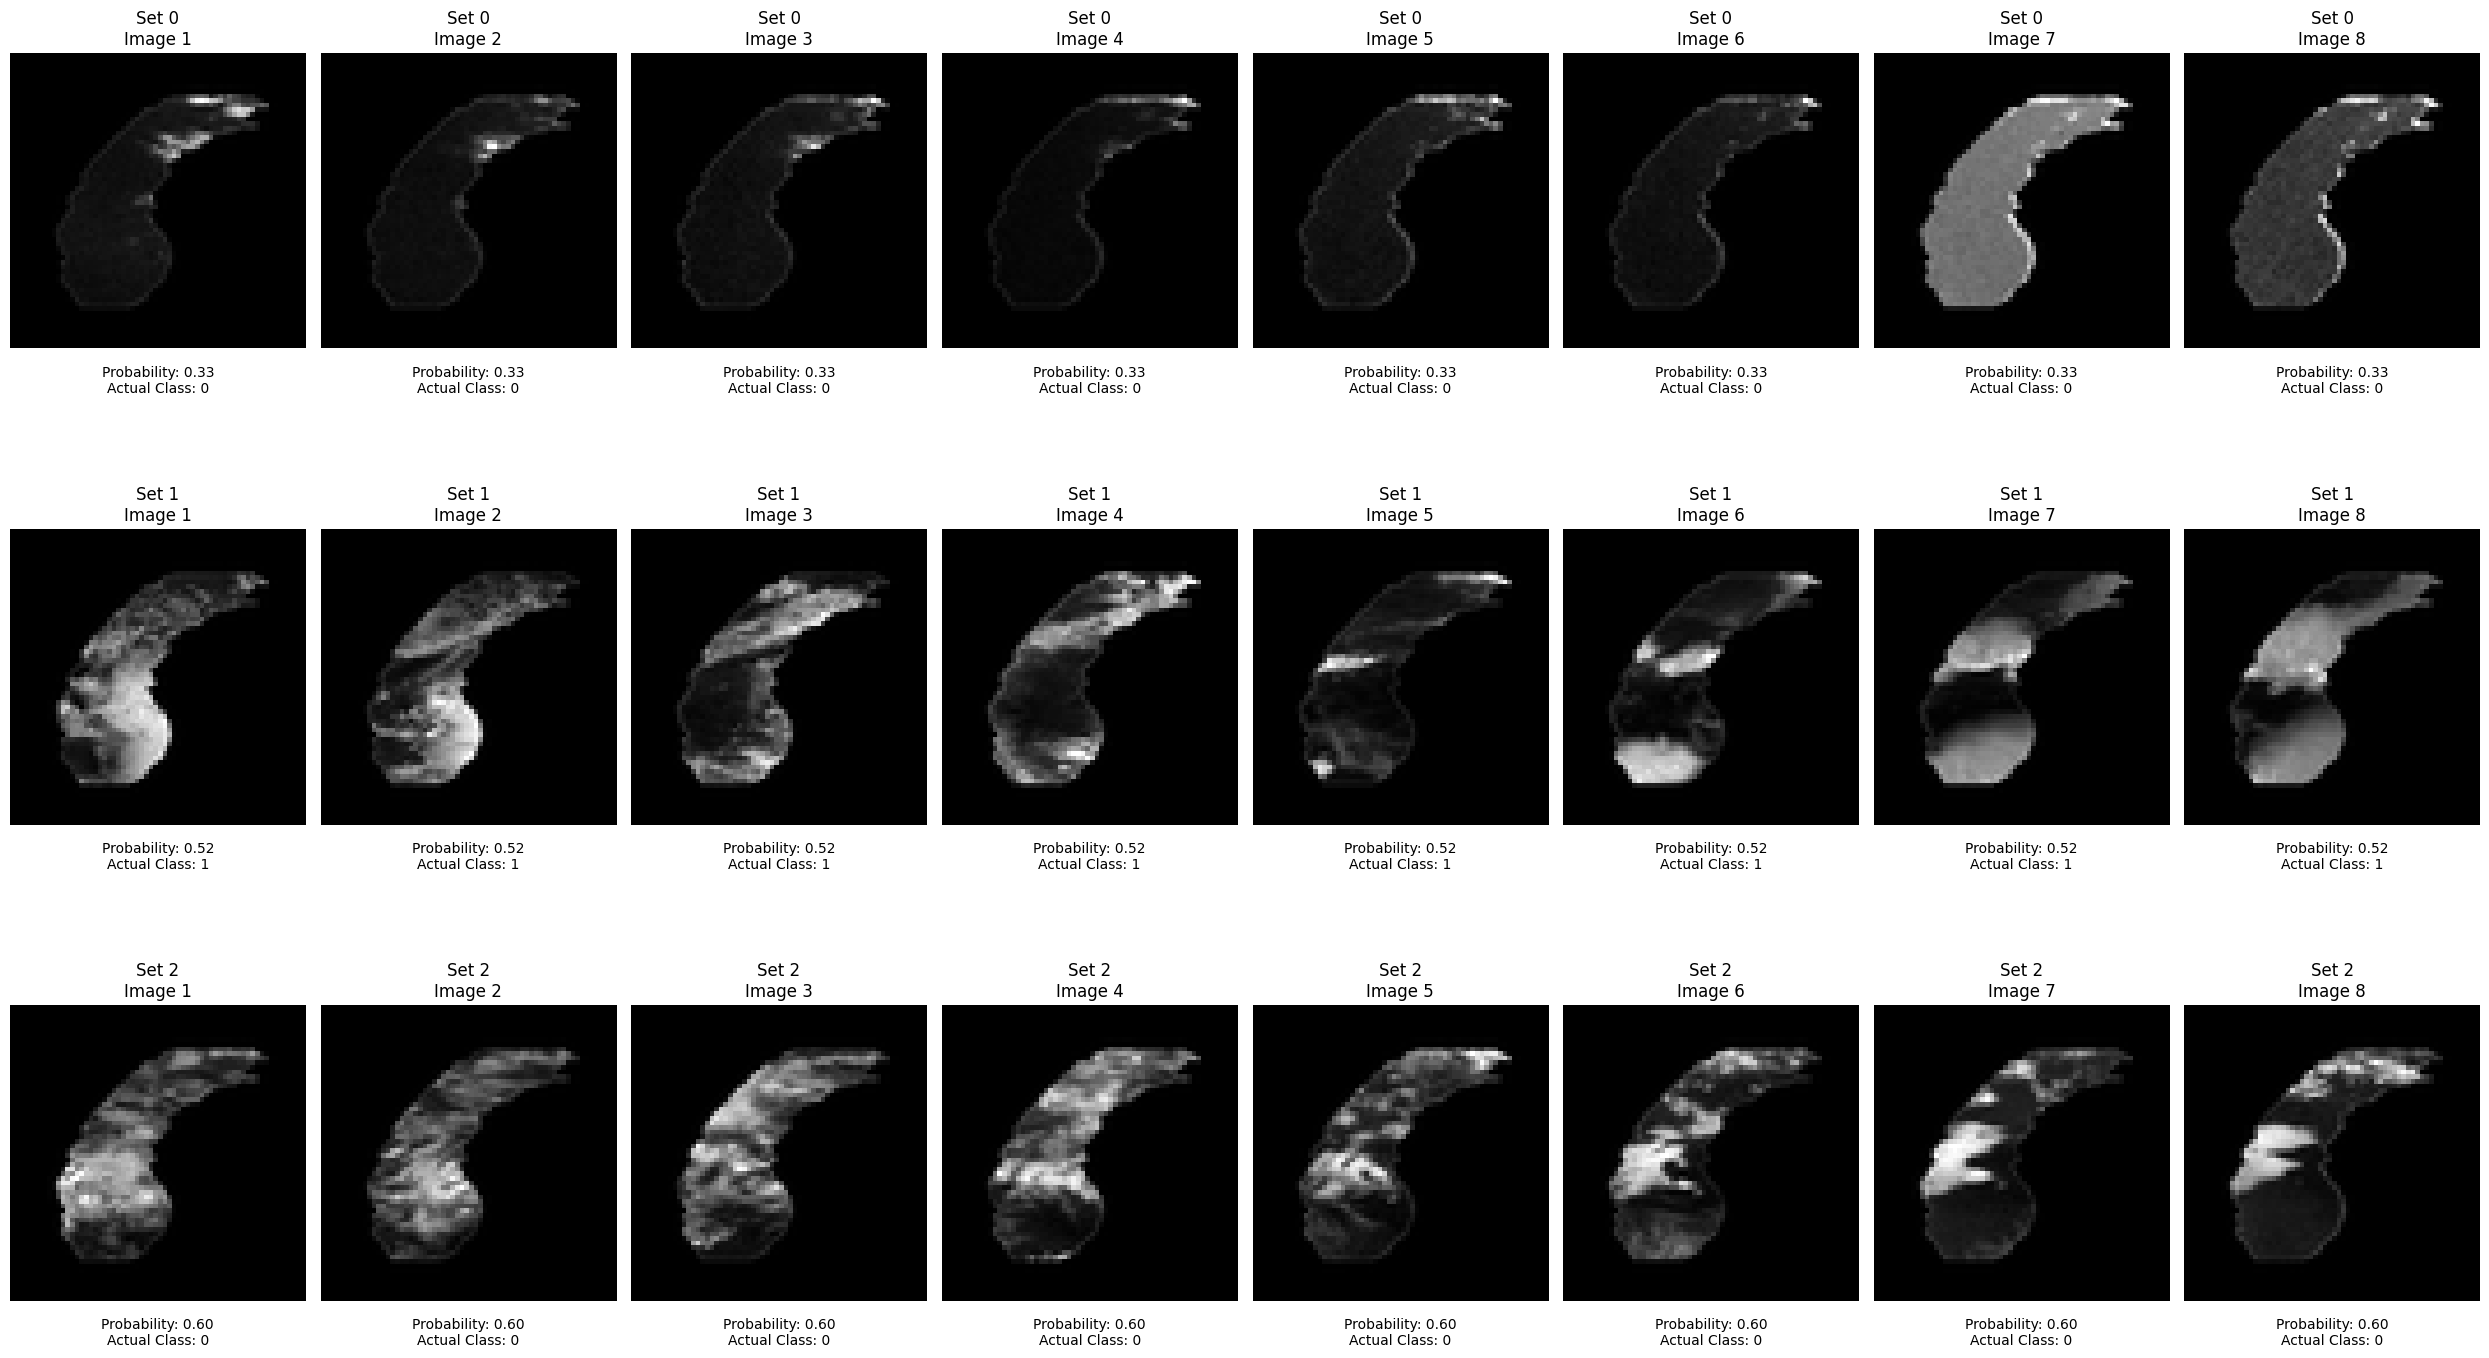

In [63]:
num_sets = 3  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

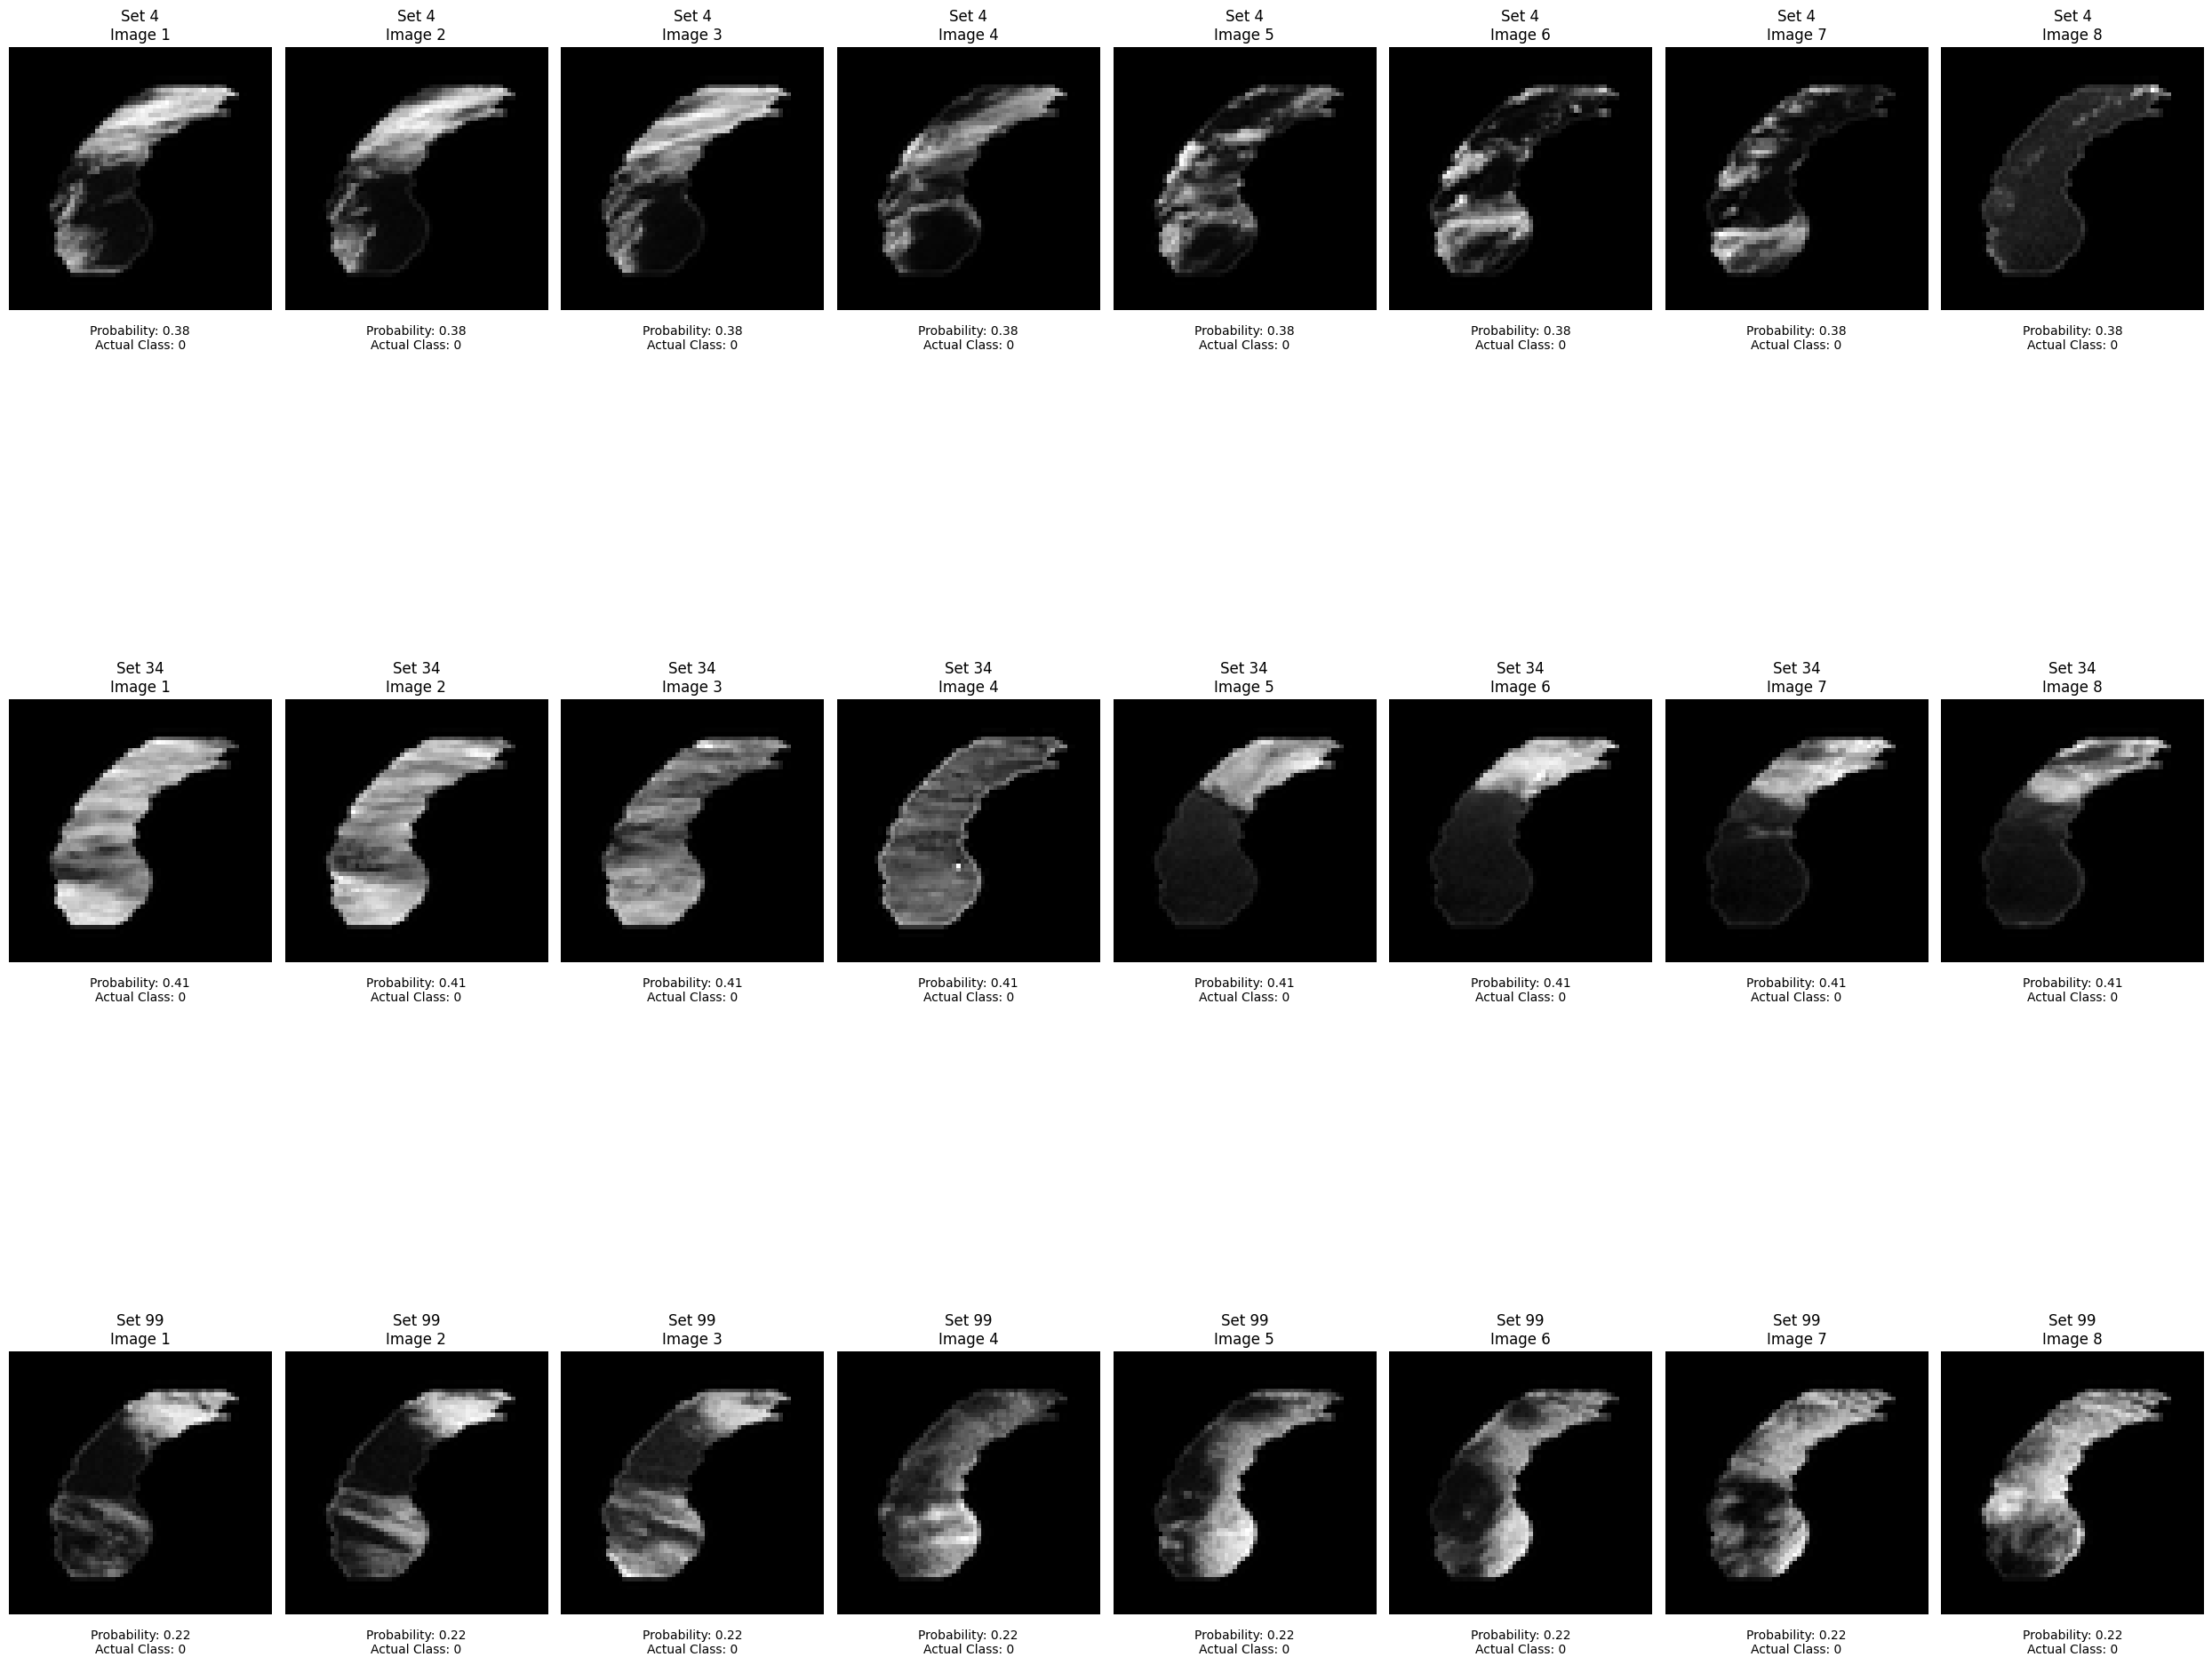

In [64]:
num_sets = [4, 34, 99] 
num_images_per_set = 8 

fig, axes = plt.subplots(3, num_images_per_set, figsize=(25, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

**Predicting for 5 days**

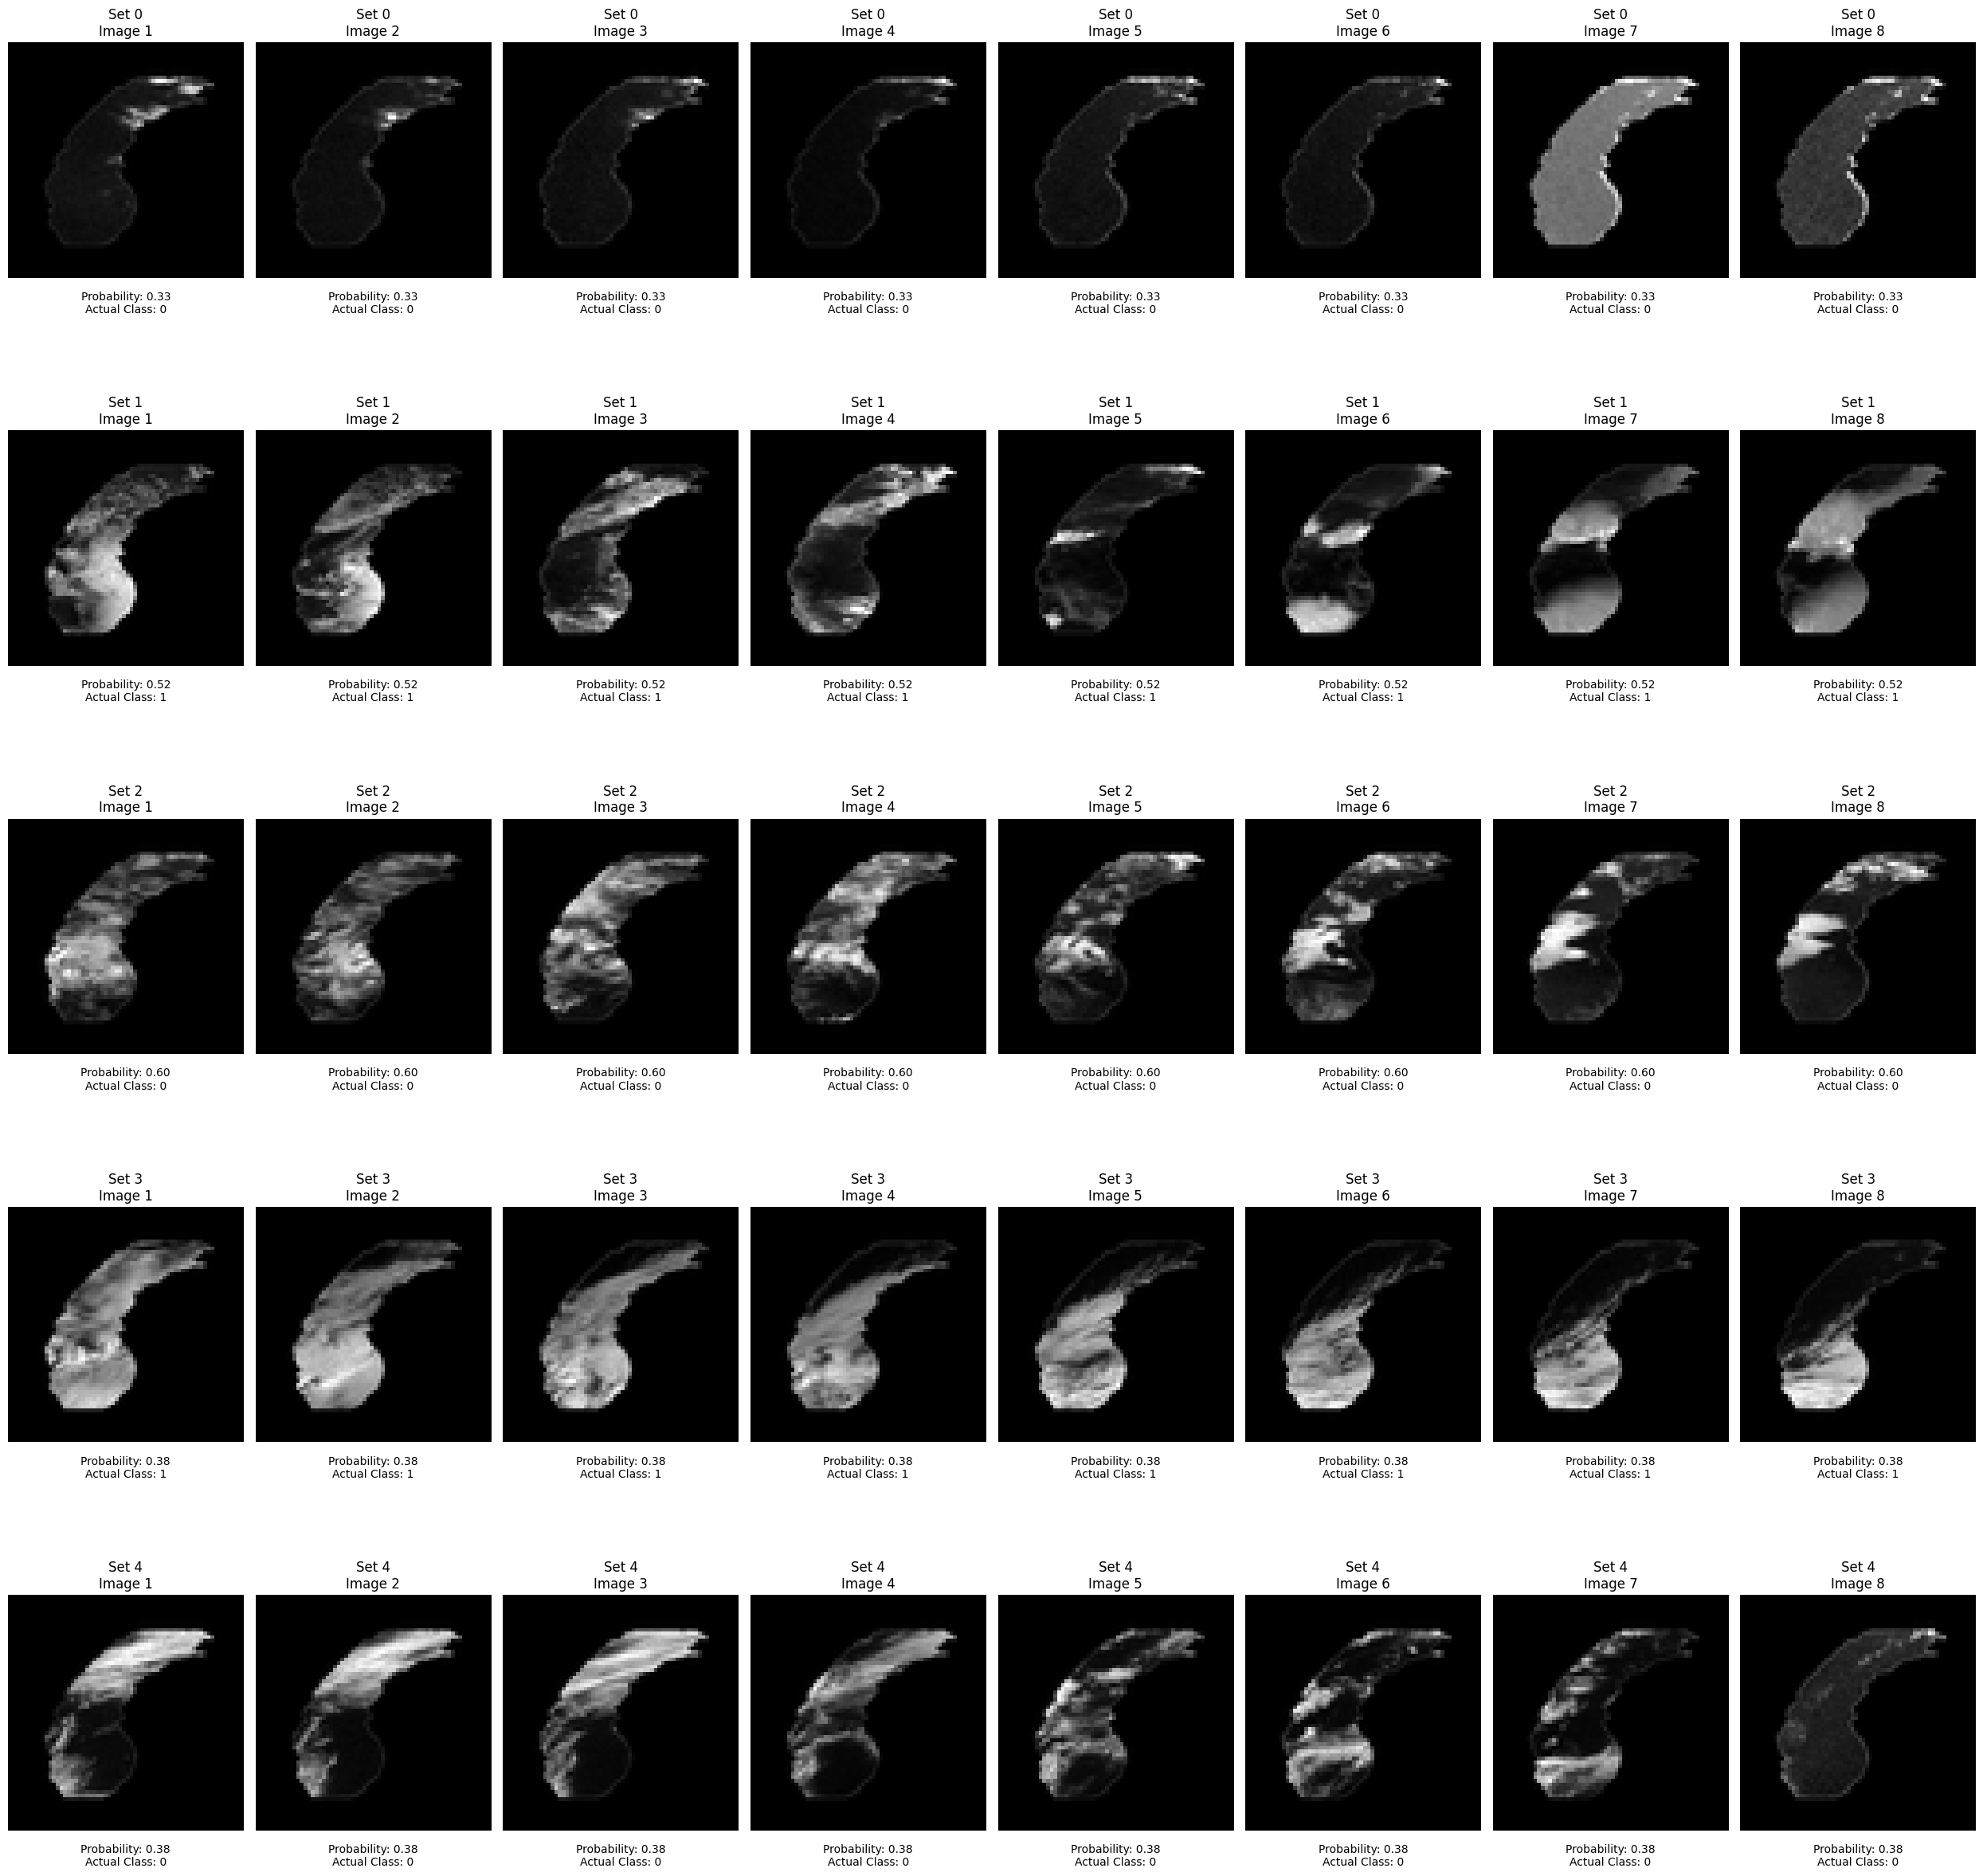

In [65]:
num_sets = 5  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

In [66]:
flattened_predicted_labels = np.array([item for sublist in predicted_labels for item in sublist])

mismatch_indices = np.where(flattened_predicted_labels != rain_val_c_mod)[0]

print("Mismatched indices:", set(mismatch_indices))

Mismatched indices: {256, 2, 3, 260, 9, 265, 11, 268, 17, 19, 20, 148, 149, 26, 286, 37, 38, 39, 40, 170, 171, 44, 172, 48, 49, 177, 181, 182, 186, 59, 60, 189, 196, 71, 72, 73, 74, 204, 205, 81, 82, 215, 90, 91, 224, 225, 226, 228, 105, 106, 235, 241, 250, 251, 255}


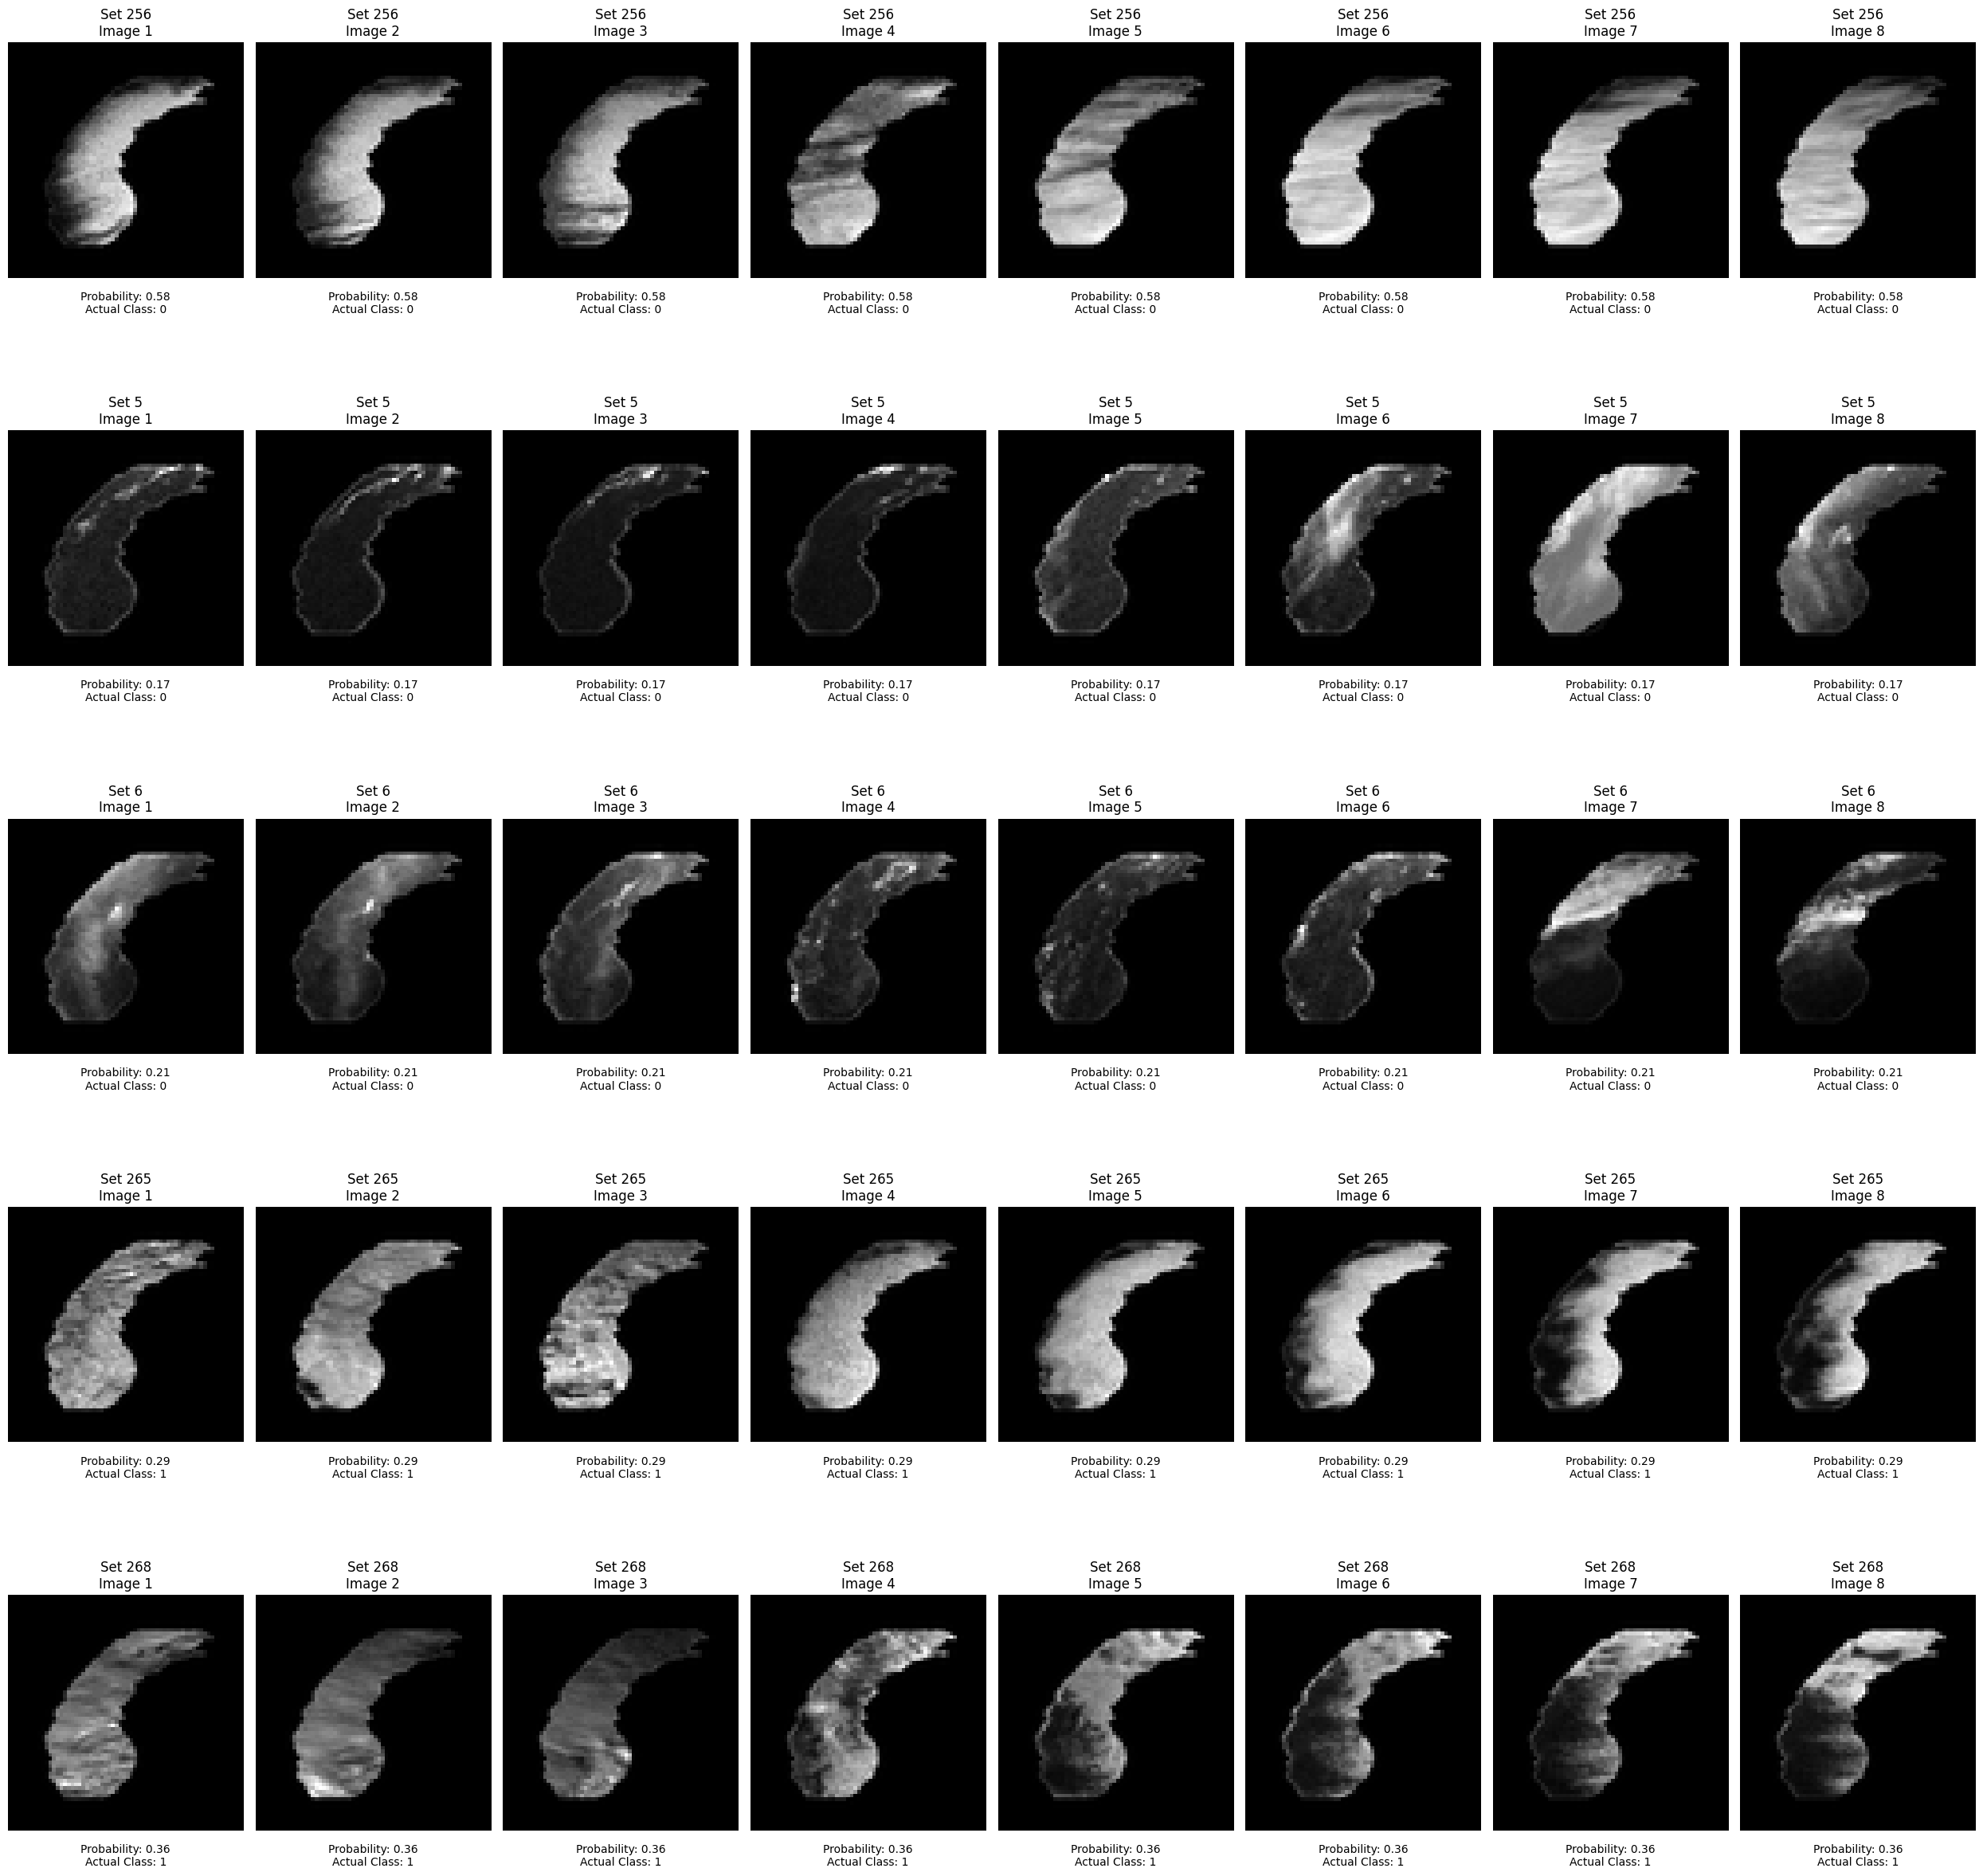

In [67]:
num_sets = [256, 5, 6, 265, 268] 
num_images_per_set = 8 

fig, axes = plt.subplots(5, num_images_per_set, figsize=(25, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

**Predicting for 7 days**

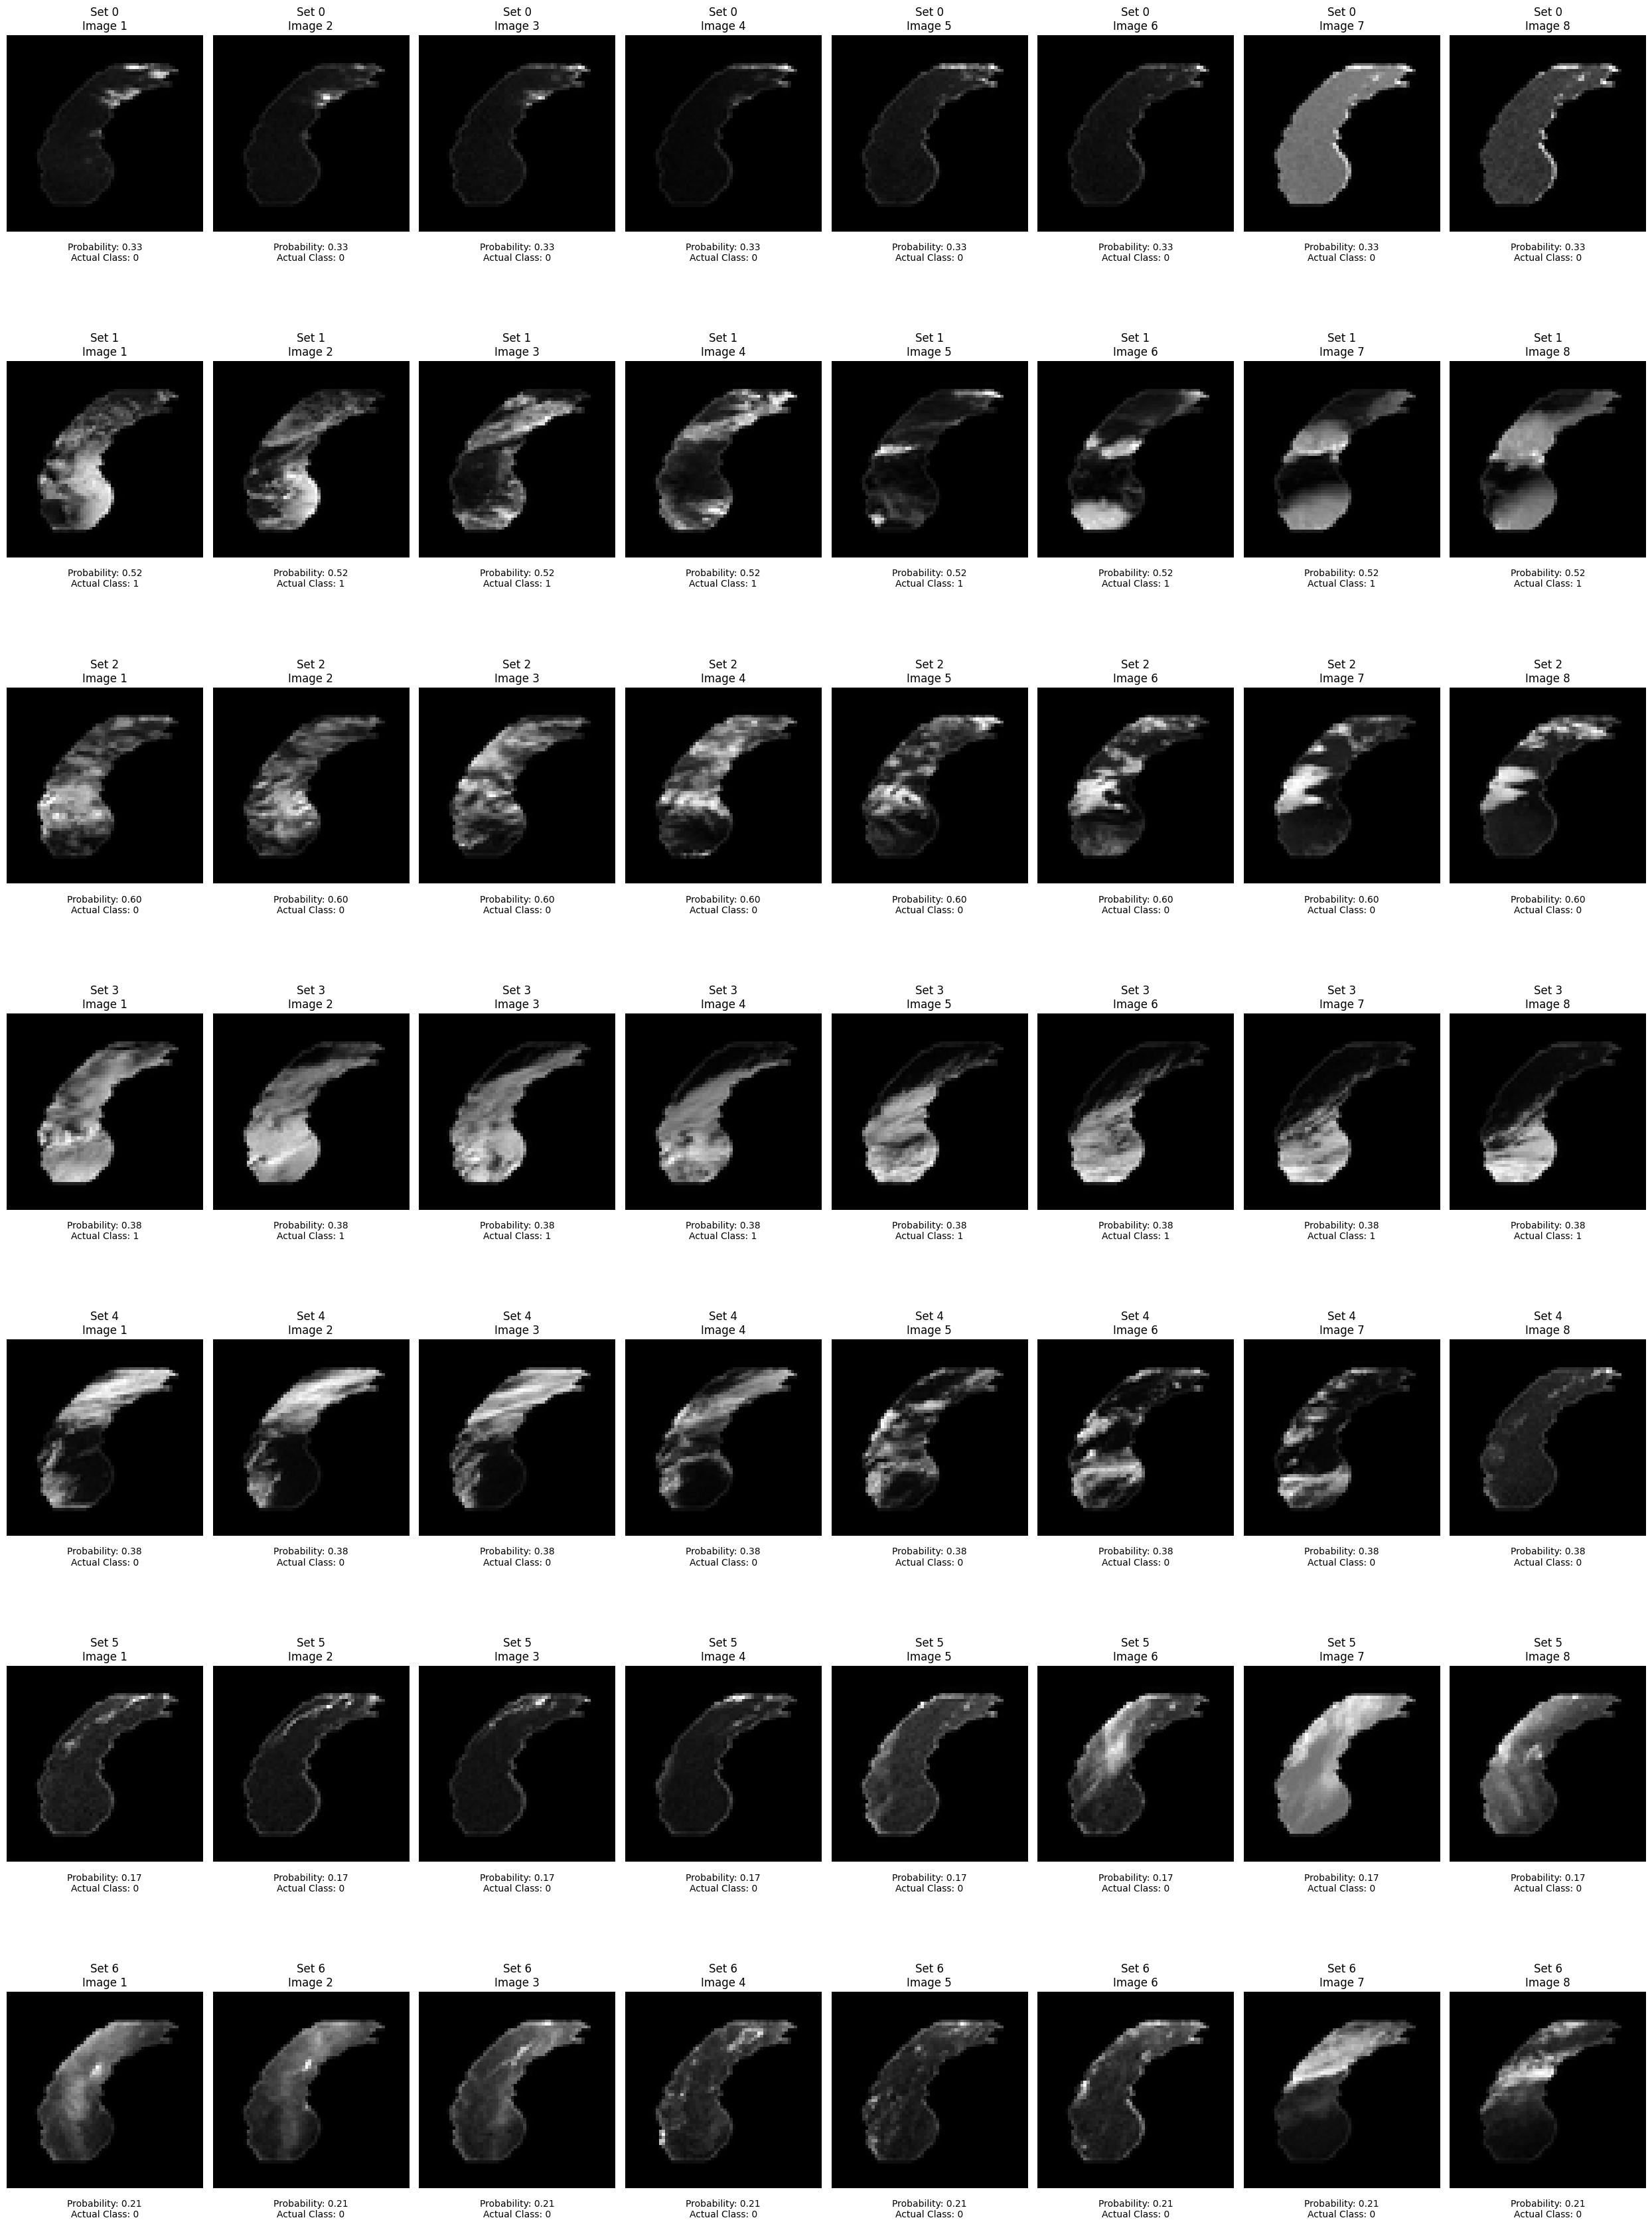

In [68]:
num_sets = 7  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

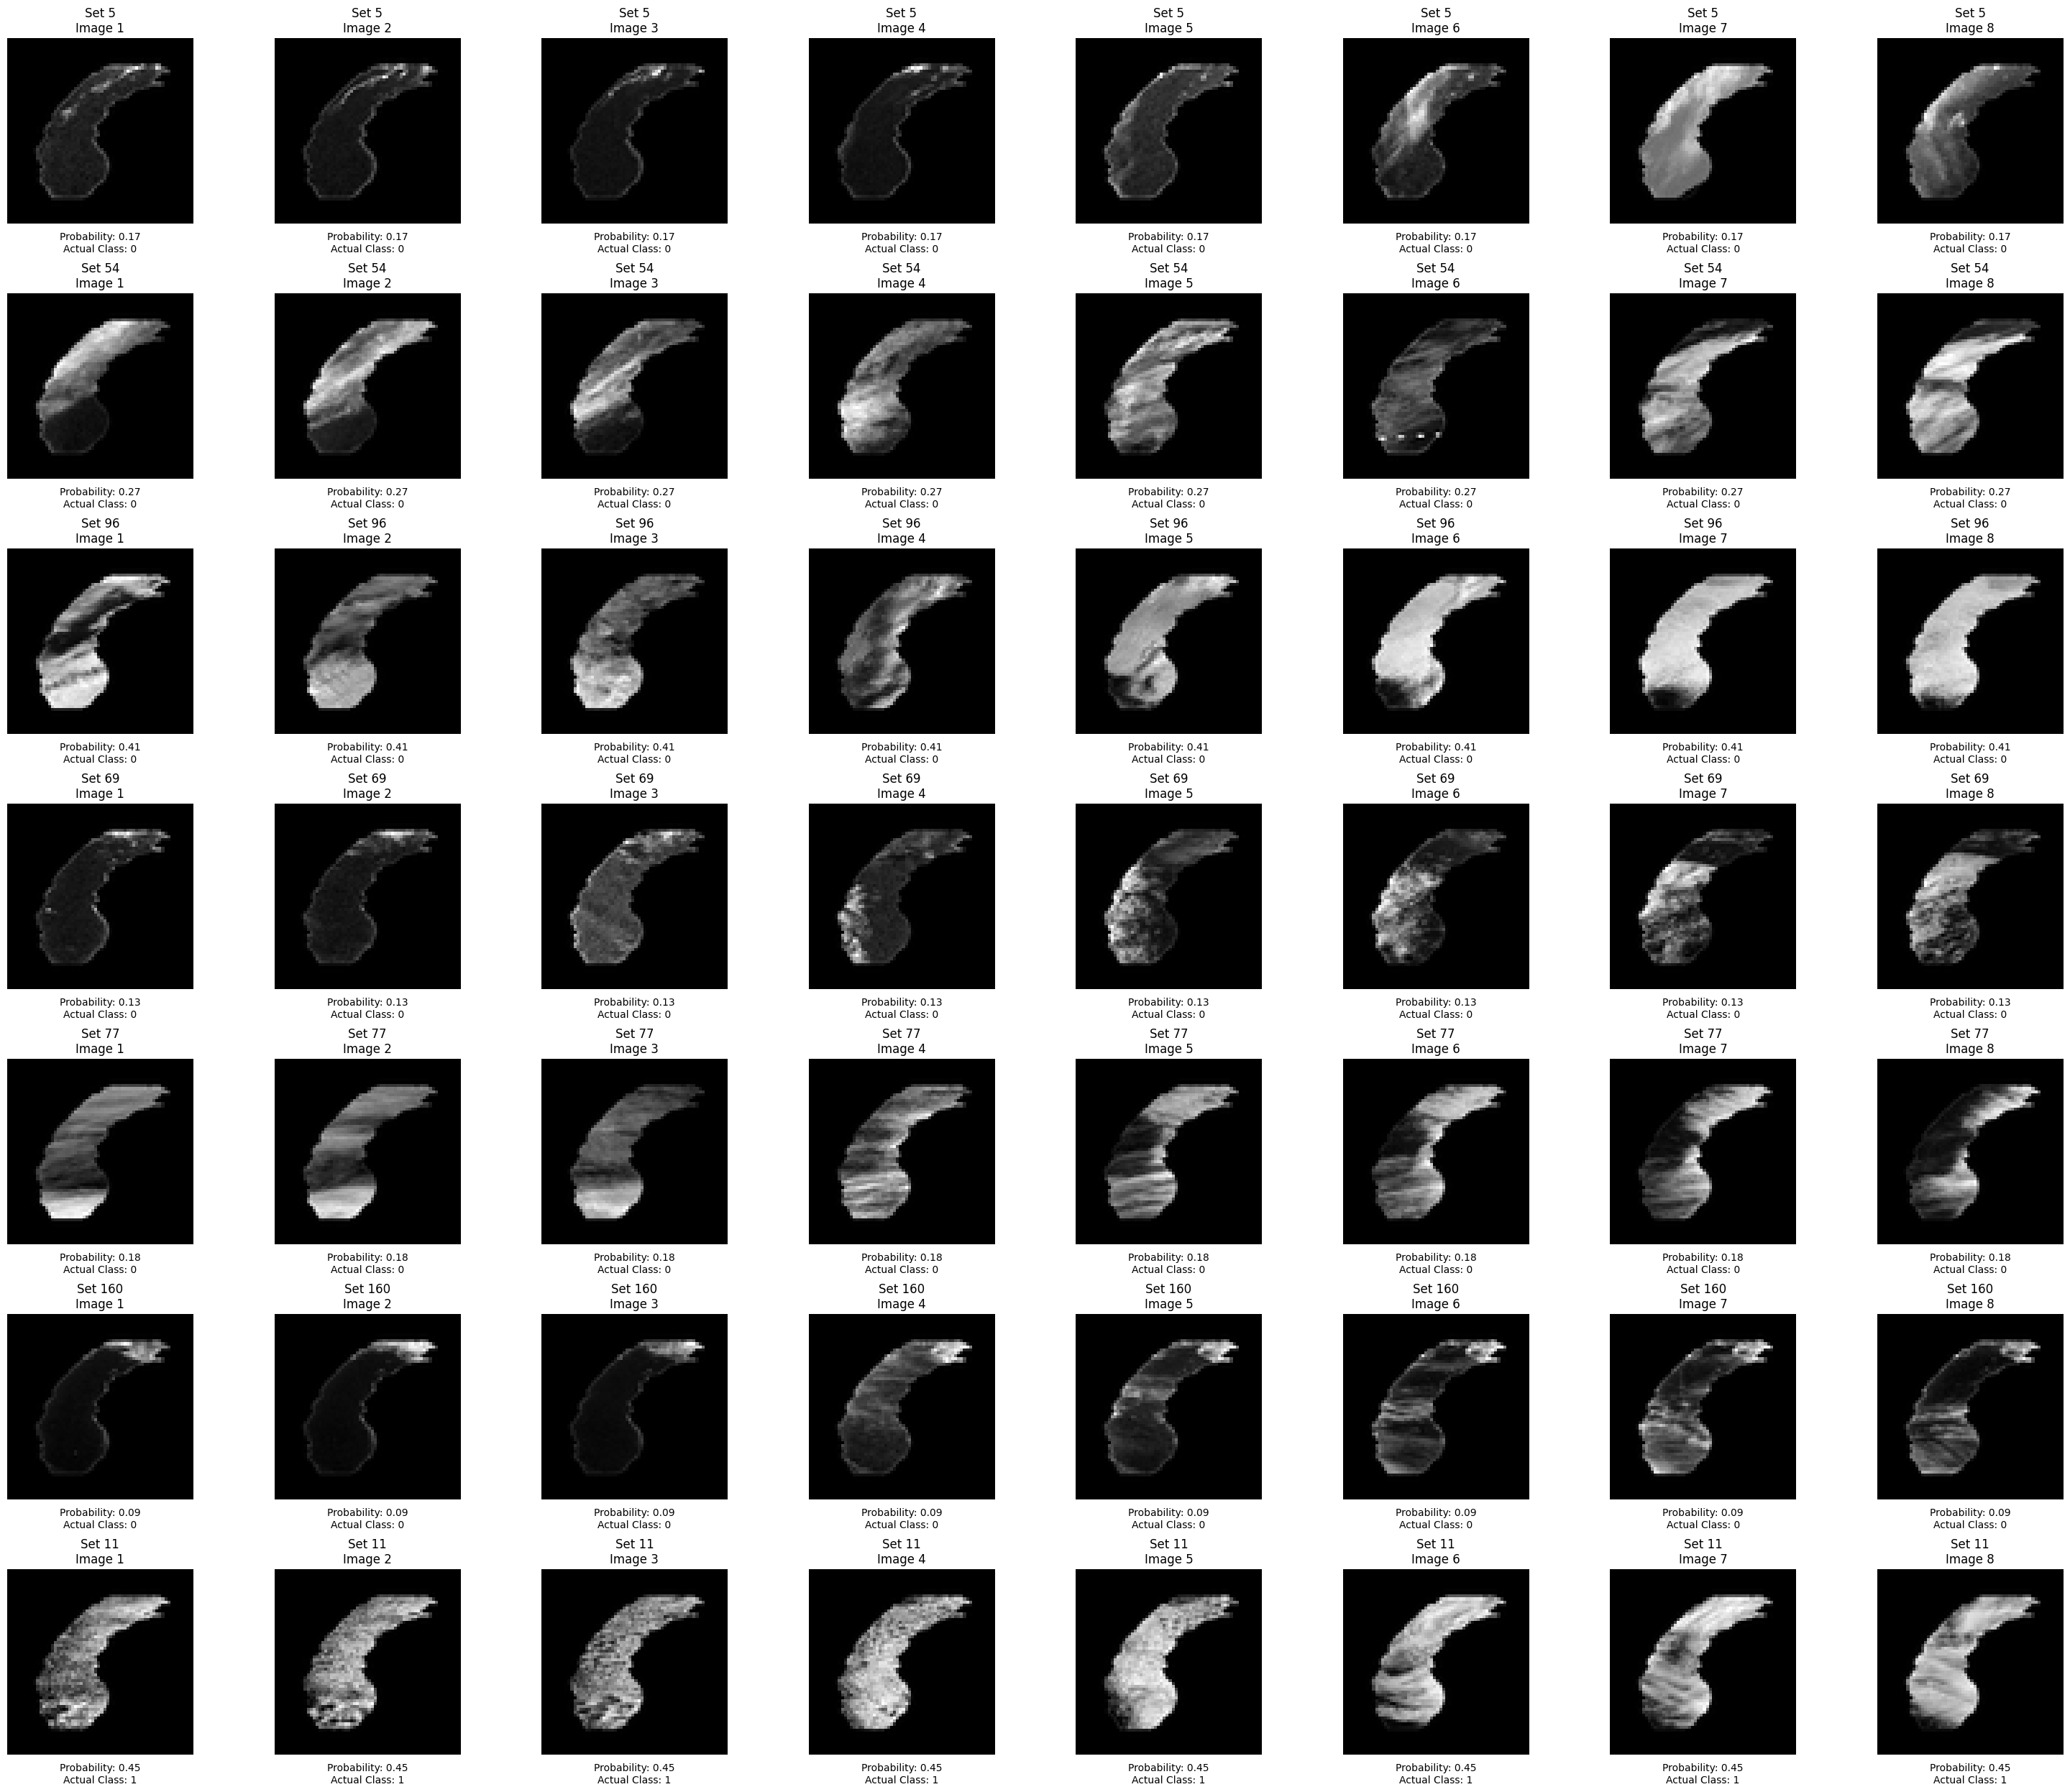

In [69]:
num_sets = [5, 54, 96,69,77,160,11] 
num_images_per_set = 8 

fig, axes = plt.subplots(7, num_images_per_set, figsize=(30, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

**Conclusion**

We learned how to work with sequential data and combine two different models to create a multimodal network.

**Issues that were Faced/Approaches tried**


We got resource exhaustion error, the issue it's not able to load all the tensors as we don't have enough GPU RAM. for Conv3d

Also, we used Conv2DLSTM and we couldn't adjust four categories. A better approach would have been using CONV3D LSTM.